In [498]:
%matplotlib inline
import re
import pandas as pd
import requests
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly as py
import seaborn as sbn
import textatistic
from bs4 import BeautifulSoup
matplotlib.style.use('ggplot')
import psycopg2
py.offline.init_notebook_mode()

In [499]:
sum_of_courses = requests.get('https://www.luther.edu/catalog/curriculum')

In [500]:
potato_soup = BeautifulSoup(sum_of_courses.text, 'html.parser')

In [501]:
departmentList = potato_soup.select('ul.childrenList a')
majorList = []
for i in departmentList:
    department = i.get('href', 'None')
    if department != 'None':
        majorList.append(department)

In [502]:
data_frame = pd.DataFrame(columns=['Department', 'CourseName', 'CourseNumber', 'Hours', 'GenEds', 'Prereqs', 'Description'])

In [503]:
webs =[]
for i in majorList:
    x = 'https://www.luther.edu/catalog/curriculum/{}'.format(i)
    webs.append(x)

In [504]:
def search_for_classes(my_soup,row):
    department = my_soup.find_all('h1', class_='pageTitle')[0].text
    courses = my_soup.find_all('div', class_='courseContainer')
    for i in courses:
        c_title = i.find_all('span', class_='courseTitle')[0].text
        c_number = i.find_all('span', class_='courseNumber')[0].text
        cr_hours = i.find_all('li')[0].text
        for part in i.find_all('li'):
            if part.find_all('i', class_='fa-li fa fa-book fa-lg') != []:
                prereks = part.text.split(' ')[1:]
                prereks = ' '.join(prereks)
            else:
                prereks = ''
        description = i.find_all('span', class_='courseDescription')[0].text
        gen_eds = []
        for i in i.find_all('span', class_='genEd'):
            gen_eds.append(i.text)
        gen_ed_string = ', '.join(gen_eds)
        data_frame.loc[row] = [department, c_title, c_number, cr_hours, gen_ed_string, prereks, description]
        row += 1
    return row

In [505]:
row = 0
for i in majorList:
    a_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(i))
    potato_soup = BeautifulSoup(a_course.text, 'html.parser')
    row = search_for_classes(potato_soup, row)

In [506]:
df.head()

Dept                                CourseName  \
0  Women and Gender Studies  Introduction to Women and Gender Studies   
1  Women and Gender Studies                     Contact Improvisation   
2  Women and Gender Studies             Literature of African Peoples   
3  Women and Gender Studies                   Biology of Race And Sex   
4  Women and Gender Studies           Sex in the Bible and the Qur'an   

  CourseNumber    Hours                                             GenEds  \
0     WGST 130  4 hours                                     Human Behavior   
1     WGST 131  4 hours           Human Behavior, Human Expression, Skills   
2     WGST 147  4 hours  Human Expression—Primary Texts, Historical, In...   
3     WGST 195  4 hours                               Natural World—Nonlab   
4     WGST 212  4 hours           Religion, Human Expression—Primary Texts   

                            Prereqs  \
0                                     
1                                     
2  PAID 111D or transfer equivalent   
3                   Junior standing   
4              REL 101, 111, or 112   

                                         Description  
0  The course combines a cross-cultural survey of...  
1  This course is an introduction to the fundamen...  
2  Modern African writers are some of the most dy...  
3  This course will introduce students to basic c...  
4  This course will explore constructions of gend...

In [507]:
updated_list = []
list_t = []
import re
for i in data_frame.Prereqs:
    updated_list.append(re.findall(r'[A-Z][A-Z][A-Z]+', i))
for i in updated_list:
    list_t.append(i)
    
new_df = pd.DataFrame(columns= ['abbv', 'relations'])

new_df['abbv'] = data_frame.CourseNumber.map(lambda x : x.split(' ')[0])

new_df['relations'] = list_t

In [508]:
series = new_df.relations.apply(pd.Series).stack().reset_index(level =1, drop=True)

series.name = 'relation'

new_df = new_df.drop('relations', axis=1).join(series)

new_df = new_df.reset_index(drop = True)

new_df = new_df.drop_duplicates()

new_df = new_df.reset_index(drop = True)

new_df = new_df.dropna(how='any')

new_df = new_df.reset_index(drop = True)

In [509]:
new_df.head()

abbv relation
0  ACCTG    ACCTG
1   AFRS     PAID
2   AFRS      SOC
3   ANTH     ANTH
4    ART      ART

In [510]:
graf = nx.DiGraph()
graf.add_nodes_from(new_df.abbv)

for index, row in new_df.iterrows():
    graf.add_edge(row['abbv'], row['relation'])

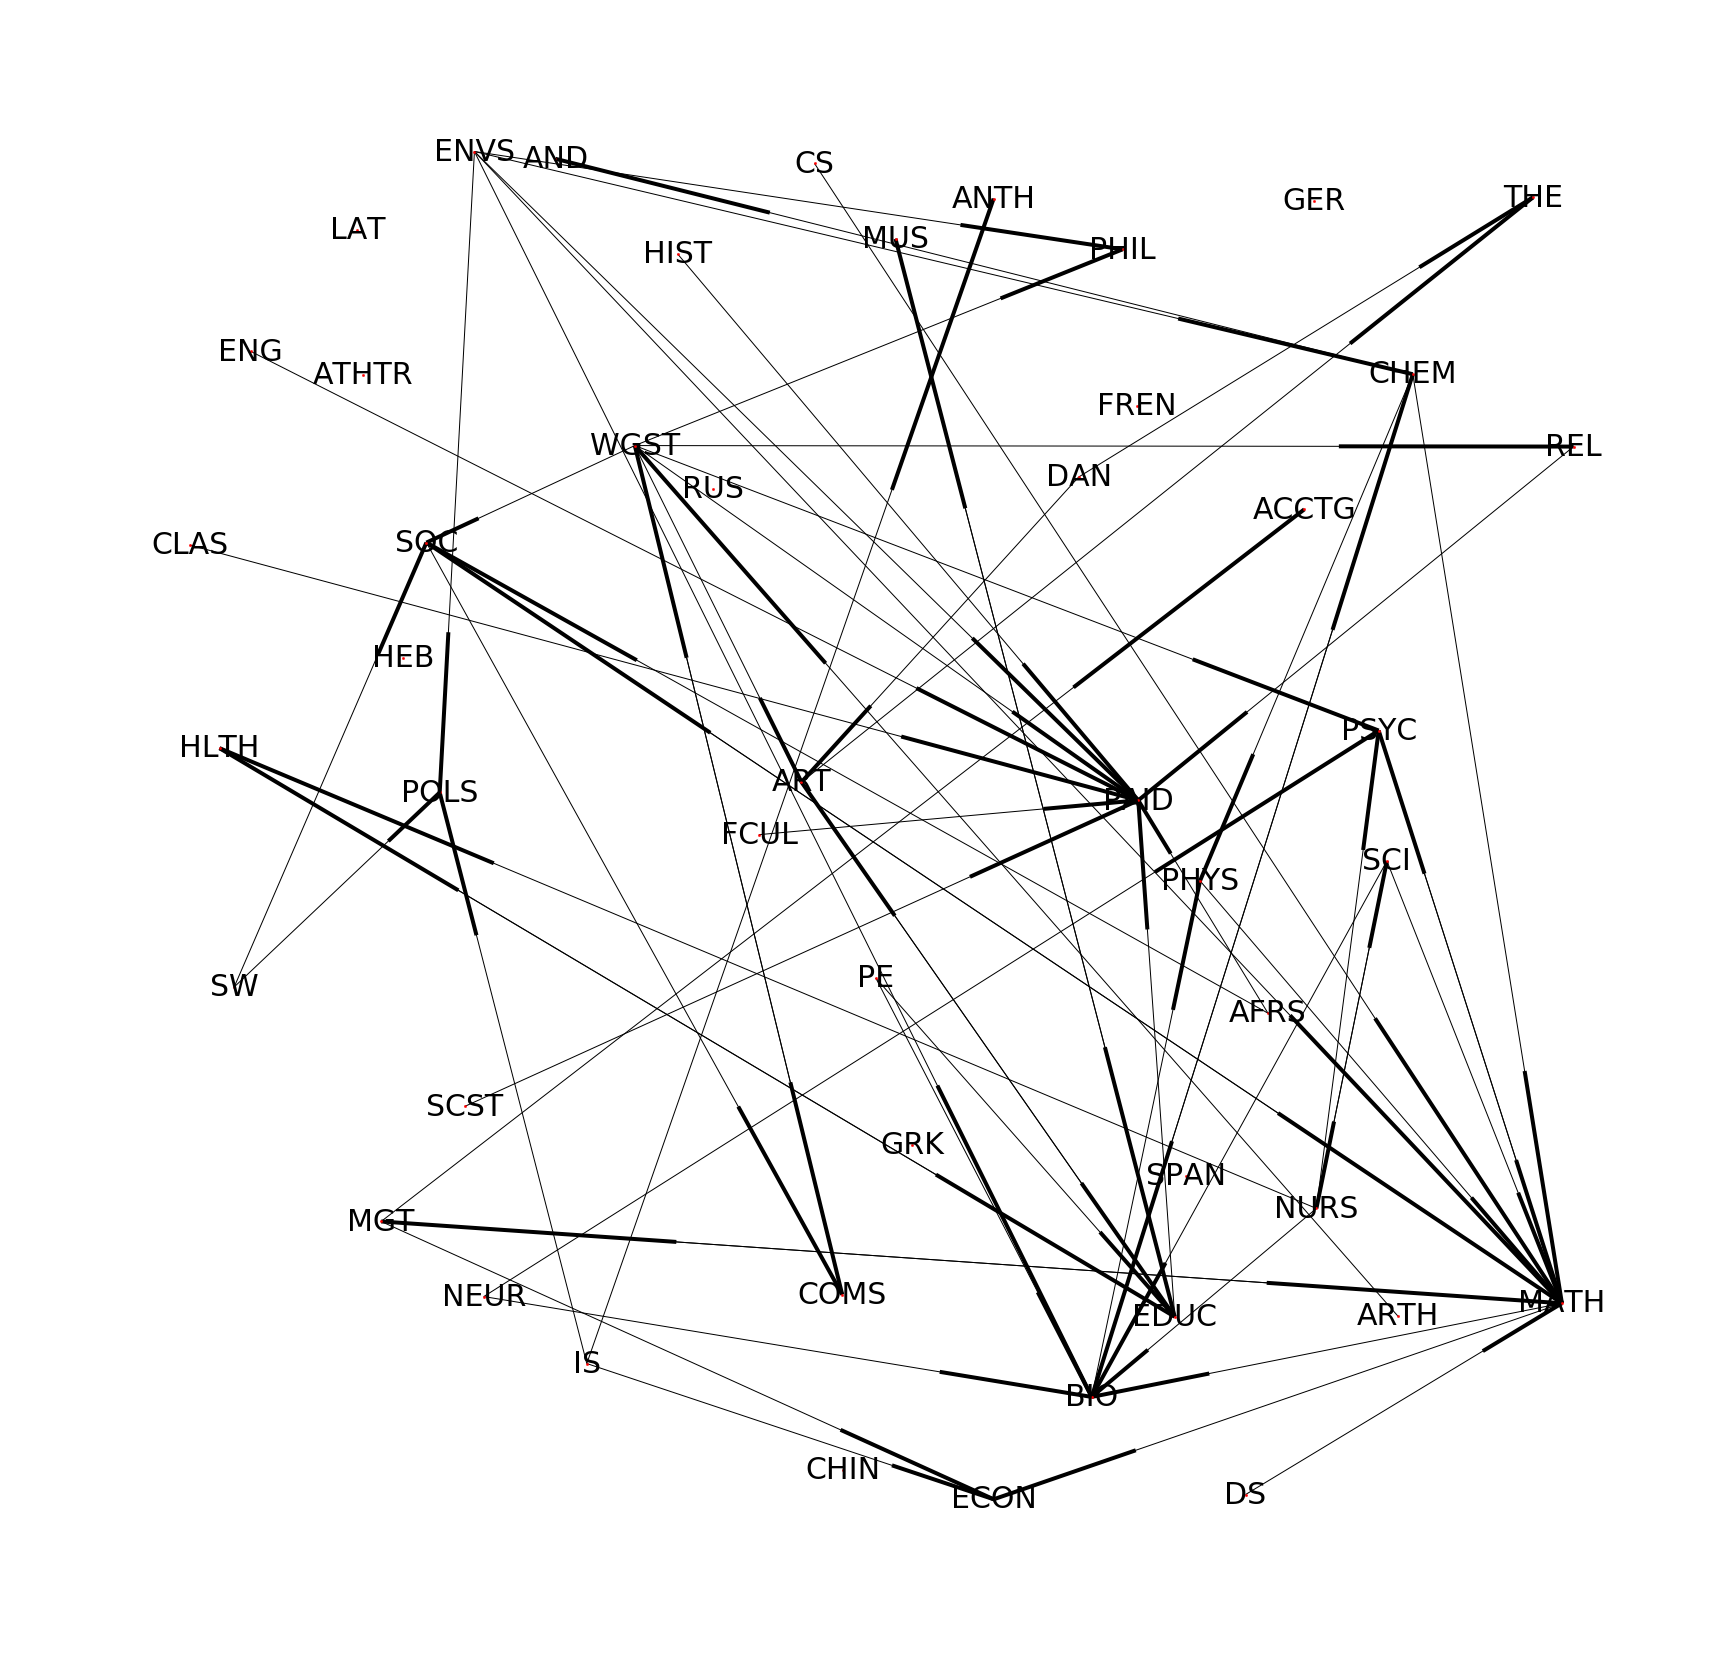

In [511]:
graffig, gax = plt.subplots(figsize = (30,30))
nx.draw(graf,nx.spring_layout(graf, k=0.4, iterations = 1), ax=gax, with_labels = True, font_size = 30, node_size = 5)

In [512]:
try:
    for i in major_list:
        a_course = requests.get('https://www.luther.edu/catalog/curriculum/{}'.format(i))
        soup = BeautifulSoup(a_course.text, 'html.parser')
        lista = []
        if soup.find_all('h1', class_='pageTitle')[0].text != 'Nordic Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Library and Information Studies' and soup.find_all('h1', class_='pageTitle')[0].text != 'Biblical Languages' and soup.find_all('h1', class_='pageTitle')[0].text != 'International Business':
            a = soup.find_all('div', class_='catalog_block')
           
            b = soup.find_all('span', class_='courseNumber')[0].text
        else:
            pass
        for i in a:
            i = i.text
            lista.append(i)
        if len(b) > 1 :
            b = b.split(' ')
        b.pop()
        b = ''.join(b)
        listb = []
        for i in lista:
            listb.append(re.findall(r'[A-Z][A-Z]+ [0-9]+', i))
        combining = [i for sublist in listb for i in sublist]
        listc = []
        for i in combining:
            i = i.split(' ')
            listc.append(i)

        for i in listc:
            del i[1]
        listc = [i for sublist in listc for i in sublist]
        listc = set(listc)
        listc = list(listc)
        new_df.set_value(-1, 'abbv', b)
        new_df.set_value(-1, 'relation', listc)
        new_df = new_df.reset_index(drop=True)
except:
    print(i)

In [513]:
series = new_df.relation.apply(pd.Series).stack().reset_index(level = 1, drop=True)

series.name = 'relations'

new_df = new_df.drop('relation', axis=1).join(series)

new_df = new_df.drop_duplicates()

new_df = new_df.sort_values(by=['abbv'])

new_df = new_df.replace('', np.nan, regex=True)

new_df = new_df.replace('^AND', np.nan, regex=True)

new_df = new_df.dropna(how='any')

new_df = new_df.reset_index(drop = True)

In [514]:
graf2 = nx.DiGraph()
graf2.add_nodes_from(new_df.abbv)


for index, row in new_df.iterrows():
    graf2.add_edge(row['abbv'], row['relations'])

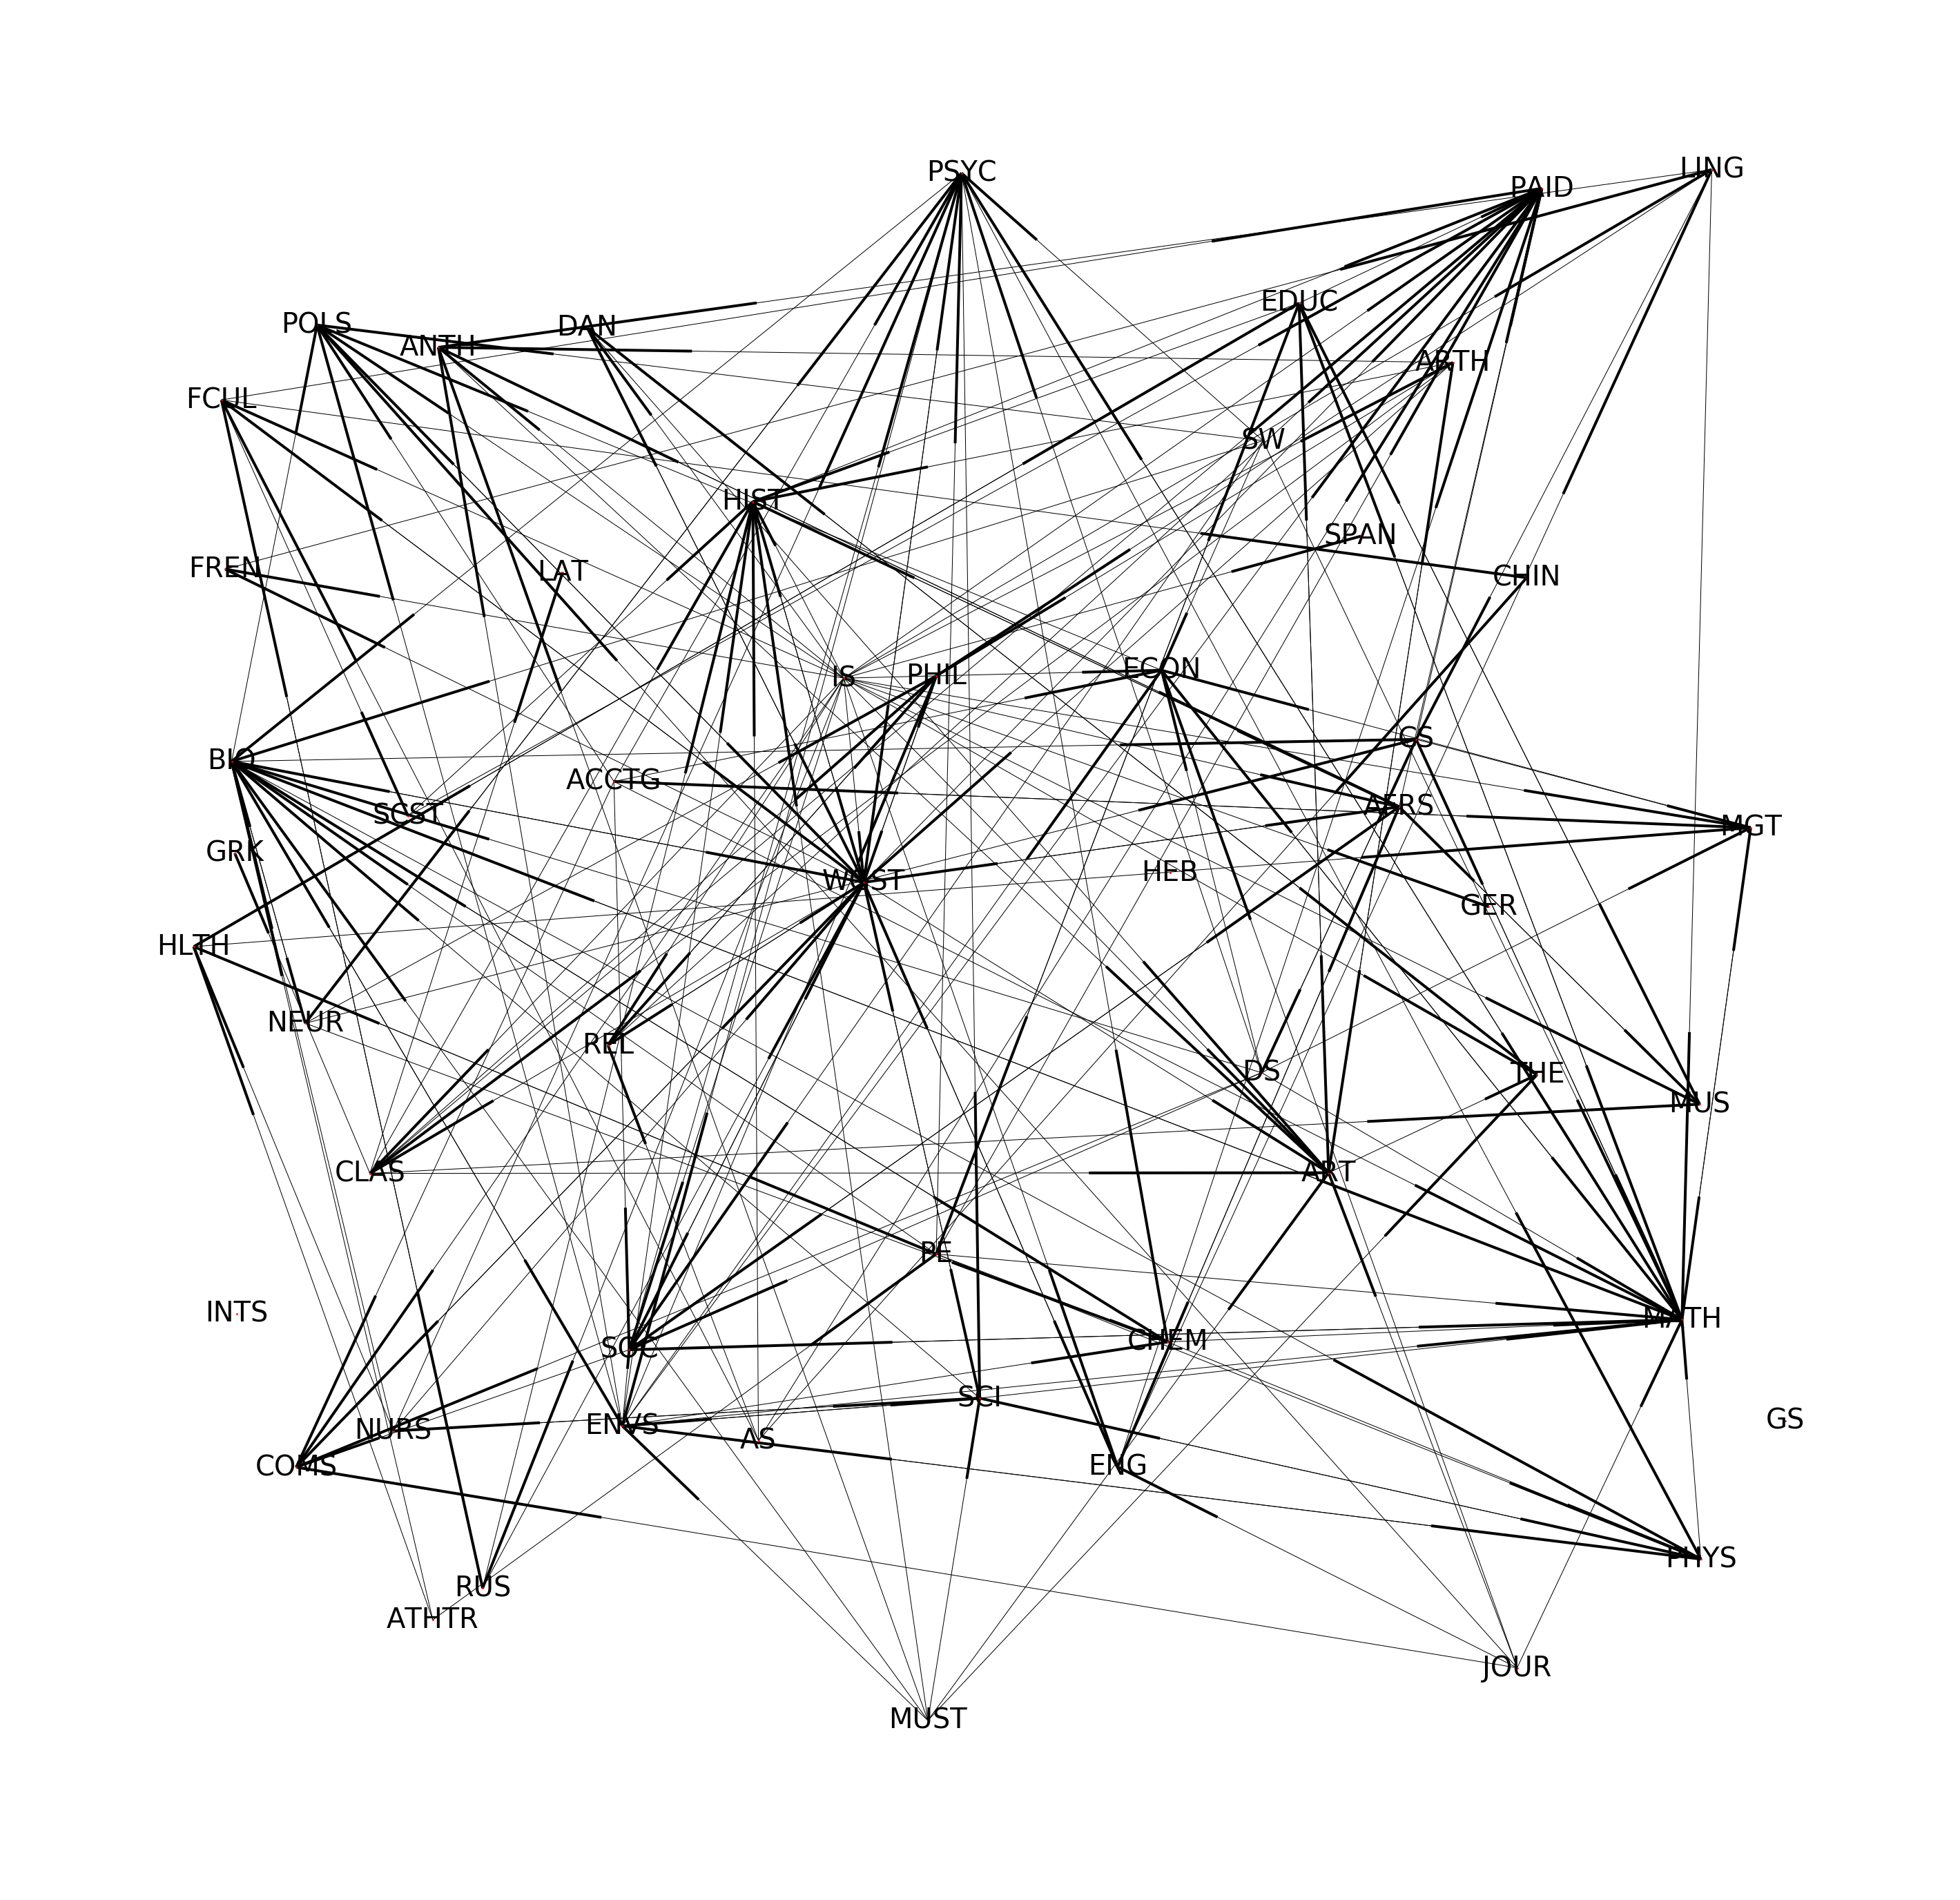

In [519]:
graf2fig, gax = plt.subplots(figsize = (50,50))
nx.draw(graf2,nx.spring_layout(graf2, k=0.4, iterations = 1), ax=gax, with_labels = True, font_size = 40, node_size = 5)

In [516]:
new_df.groupby('relations')['abbv'].count().head()

relations
ACCTG     2
AFRS      8
ANTH      7
ART      10
ARTH      3
Name: abbv, dtype: int64

In [517]:
new_df.groupby('relations')['abbv'].count().head(15) > 10

relations
ACCTG    False
AFRS     False
ANTH     False
ART      False
ARTH     False
AS       False
ATHTR    False
BIO       True
CHEM     False
CHIN     False
CLAS     False
COMS     False
CS       False
DAN      False
DS       False
Name: abbv, dtype: bool